In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import namedtuple, deque
import torch.optim as optim

# get the environment and default brain
env = UnityEnvironment(file_name="./Banana.app")
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [2]:
class QNetwork(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [3]:
class Agent():

    def __init__(self, state_size, action_size, seed):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        # Q-Network
        self.qnetwork_local = QNetwork(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    def step(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)

    def act(self, state, eps=0.):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # Get max predicted Q values (for next states) from target model
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        # Compute Q targets for current states 
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # Get expected Q values from local model
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        # Compute loss
        loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     

    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)
    
agent = Agent(state_size=37, action_size=4, seed=0)    

In [4]:
def dqn(n_episodes=1500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.70):

    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):        
        env_info = env.reset(train_mode=True)[brain_name] 
        state = env_info.vector_observations[0]         
        score = 0
        while True:
            action = agent.act(state, eps)            
            env_info = env.step(action)[brain_name] 
            next_state = env_info.vector_observations[0] 
            reward = env_info.rewards[0] 
            done = env_info.local_done[0]                         
            agent.step(state, action, reward, next_state, done)            
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(n_episodes, np.mean(scores)))
    torch.save(agent.qnetwork_local.state_dict(), 'checkpoint.pth')
   
    return scores

scores = dqn()

Episode 100	Average Score: 2.57
Episode 200	Average Score: 8.60
Episode 300	Average Score: 11.14
Episode 400	Average Score: 15.29
Episode 500	Average Score: 16.02
Episode 600	Average Score: 15.56
Episode 700	Average Score: 16.23
Episode 800	Average Score: 15.08
Episode 900	Average Score: 16.73
Episode 1000	Average Score: 15.66
Episode 1100	Average Score: 16.55
Episode 1200	Average Score: 16.17
Episode 1300	Average Score: 16.26
Episode 1400	Average Score: 15.30
Episode 1500	Average Score: 16.51

Environment solved in 1500 episodes!	Average Score: 14.24


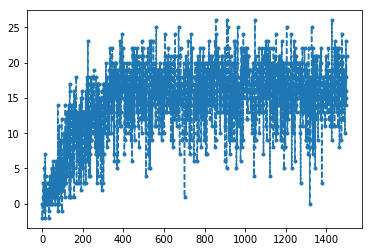

In [6]:
import matplotlib.pyplot as plt
plt.plot(scores, '.--');

Episode 0	Score: 16.84
Episode 1	Score: 15.11
Episode 2	Score: 12.65
Episode 3	Score: 11.25
Episode 4	Score: 13.00
Episode 5	Score: 11.16
Episode 6	Score: 12.20
Episode 7	Score: 12.16
Episode 8	Score: 16.27
Episode 9	Score: 13.28
Episode 10	Score: 13.95
Episode 11	Score: 10.72
Episode 12	Score: 13.00
Episode 13	Score: 0.00
Episode 14	Score: 15.38
Episode 15	Score: 15.00
Episode 16	Score: 16.29
Episode 17	Score: 11.31
Episode 18	Score: 14.32
Episode 19	Score: 14.13
Episode 20	Score: 15.40
Episode 21	Score: 16.13
Episode 22	Score: 6.12
Episode 23	Score: 9.73
Episode 24	Score: 16.54
Episode 25	Score: 11.72
Episode 26	Score: 12.55
Episode 27	Score: 14.57
Episode 28	Score: 17.43
Episode 29	Score: 14.90
Episode 30	Score: 11.48
Episode 31	Score: 12.40
Episode 32	Score: 10.99
Episode 33	Score: 12.65
Episode 34	Score: 10.31
Episode 35	Score: 16.37
Episode 36	Score: 15.40
Episode 37	Score: 15.87
Episode 38	Score: 14.91
Episode 39	Score: 12.69
Episode 40	Score: 11.71
Episode 41	Score: 17.34
Episo

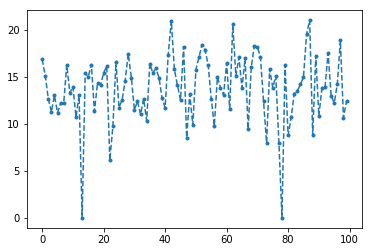

In [7]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

scores = []                        
scores_window = deque(maxlen=100)
total_score = []

for i_episode in range(100):
    env_info = env.reset(train_mode=False)[brain_name] 
    state = env_info.vector_observations[0] 
    
    score = 0
    
    while True:
        action = agent.act(state)        
        env_info = env.step(action)[brain_name] 
        state = env_info.vector_observations[0] 
        reward = env_info.rewards[0]         
        score += reward        
        done = env_info.local_done[0]        
        if done:
            break 
       
        scores_window.append(score) 
        scores.append(score)  

    print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
    print('\rEpisode {}\tScore: {:.2f}'.format(i_episode, np.mean(scores_window)))
    
    total_score.append( np.mean(scores_window) )

print("Total avaerage: " , np.mean(total_score) )
    
plt.plot(total_score, '.--');            

In [8]:
env.close()